# Assignment 3

[TOC]

## Exercise 1

Sample codes from the the tutorial <a>https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
from sklearn import metrics

# initialize the training-set and test-set variables
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
training_set_loader = torch.utils.data.DataLoader(training_set, batch_size=4,
                                                  shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                              shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
           'frog', 'horse', 'ship', 'truck')


# functions to show an image
def show_image(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



Files already downloaded and verified
Files already downloaded and verified


In [2]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# get an instance of our CNN class
net = Net()


In [3]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [4]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(training_set_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.213
[1,  4000] loss: 1.850
[1,  6000] loss: 1.689
[1,  8000] loss: 1.588
[1, 10000] loss: 1.545
[1, 12000] loss: 1.480
[2,  2000] loss: 1.431
[2,  4000] loss: 1.374
[2,  6000] loss: 1.364
[2,  8000] loss: 1.331
[2, 10000] loss: 1.306
[2, 12000] loss: 1.292
Finished Training


In [5]:
########################################################################
# 5. Test the network on the whole test data

correct = 0
total = 0
with torch.no_grad():
    for data in test_set_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


Accuracy of the network on the 10000 test images: 54 %


In [6]:
########################################################################
# That looks waaay better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did

# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
actual = []
predictions = []
with torch.no_grad():
    for data in test_set_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            predictions.append(classes[predicted[i]])
            actual.append(classes[labels[i]])
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


1. To generate a 10 x 10 confusion matrix

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function is going to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

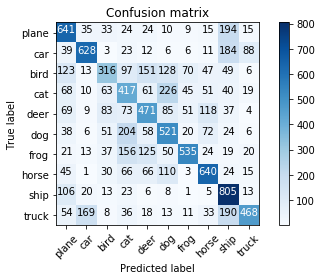

In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


labels = list(classes)
plt.figure()
matrix = metrics.confusion_matrix(actual, predictions, labels)
plot_confusion_matrix(matrix, labels)
plt.show()


2. test with different masks

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn import metrics

import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function is going to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


class Net(nn.Module):
    """
    This class is my customized CNN model.
    It receives an optional 2-dimension tuple to set the mast size
    """

    def __init__(self, mask_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, mask_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


######################################################################
# common variables

# initialize the training-set and test-set variables
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

training_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
training_set_loader = torch.utils.data.DataLoader(training_set, batch_size=4,
                                                  shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                              shuffle=False, num_workers=2)

class_tuple = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
               'frog', 'horse', 'ship', 'truck')
class_list = list(class_tuple)


Files already downloaded and verified
Files already downloaded and verified


In [10]:
def exercise_1_2(mask_size):
    """
    This function is going to be called to train the data,
        and test with different masks.
    :param mask_size: a 2-dimension tuple to set the mask size
    :return:
    """

    ############################################################
    # create an object of our CNN model with the specific mask
    net = Net(mask_size)

    ############################################################
    # Define a Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    ############################################################
    # train it with the training data
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(training_set_loader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

    ############################################################
    # test it with the testing set
    correct = 0
    total = 0
    actual_values = []
    predicted_values = []
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in test_set_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(4):
                predicted_values.append(class_tuple[predicted[i]])
                actual_values.append(class_tuple[labels[i]])
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))

    ############################################################
    # generate the confusion matrix
    plt.figure()
    matrix = metrics.confusion_matrix(actual_values, predicted_values, class_list)
    plot_confusion_matrix(matrix, class_list)
    plt.show()


* train and test with mask of (3, 3)

[1,  2000] loss: 2.187
[1,  4000] loss: 1.868
[1,  6000] loss: 1.675
[1,  8000] loss: 1.589
[1, 10000] loss: 1.503
[1, 12000] loss: 1.457
[2,  2000] loss: 1.378
[2,  4000] loss: 1.338
[2,  6000] loss: 1.338
[2,  8000] loss: 1.324
[2, 10000] loss: 1.272
[2, 12000] loss: 1.255
Finished Training
Accuracy of the network on the 10000 test images: 55 %


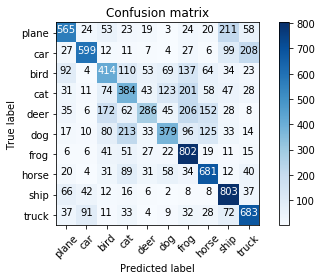

In [11]:
exercise_1_2((3, 3))

* train and test with mask of (3, 4)

[1,  2000] loss: 2.197
[1,  4000] loss: 1.884
[1,  6000] loss: 1.697
[1,  8000] loss: 1.561
[1, 10000] loss: 1.509
[1, 12000] loss: 1.446
[2,  2000] loss: 1.407
[2,  4000] loss: 1.344
[2,  6000] loss: 1.340
[2,  8000] loss: 1.296
[2, 10000] loss: 1.302
[2, 12000] loss: 1.273
Finished Training
Accuracy of the network on the 10000 test images: 56 %


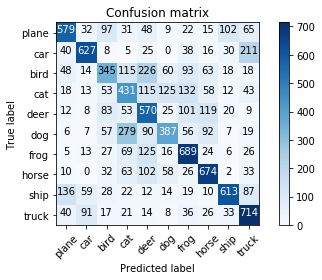

In [23]:
exercise_1_2((3, 4))

* train and test with mask of (3, 5)

[1,  2000] loss: 2.286
[1,  4000] loss: 1.949
[1,  6000] loss: 1.746
[1,  8000] loss: 1.639
[1, 10000] loss: 1.541
[1, 12000] loss: 1.506
[2,  2000] loss: 1.415
[2,  4000] loss: 1.392
[2,  6000] loss: 1.379
[2,  8000] loss: 1.316
[2, 10000] loss: 1.320
[2, 12000] loss: 1.280
Finished Training
Accuracy of the network on the 10000 test images: 56 %


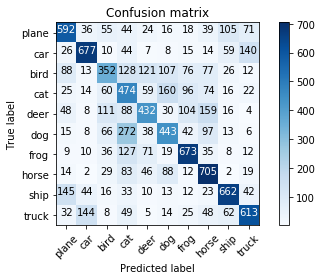

In [12]:
exercise_1_2((3, 5))

* train and test with mask of (4, 4)

[1,  2000] loss: 2.199
[1,  4000] loss: 1.857
[1,  6000] loss: 1.699
[1,  8000] loss: 1.593
[1, 10000] loss: 1.521
[1, 12000] loss: 1.484
[2,  2000] loss: 1.411
[2,  4000] loss: 1.368
[2,  6000] loss: 1.320
[2,  8000] loss: 1.322
[2, 10000] loss: 1.276
[2, 12000] loss: 1.297
Finished Training
Accuracy of the network on the 10000 test images: 55 %


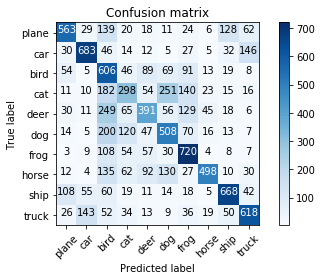

In [22]:
exercise_1_2((4, 4))

* train and test with mask of (4, 5)

[1,  2000] loss: 2.187
[1,  4000] loss: 1.884
[1,  6000] loss: 1.730
[1,  8000] loss: 1.622
[1, 10000] loss: 1.557
[1, 12000] loss: 1.496
[2,  2000] loss: 1.444
[2,  4000] loss: 1.394
[2,  6000] loss: 1.347
[2,  8000] loss: 1.342
[2, 10000] loss: 1.314
[2, 12000] loss: 1.267
Finished Training
Accuracy of the network on the 10000 test images: 56 %


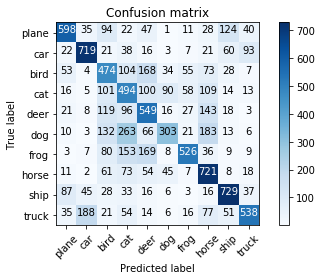

In [24]:
exercise_1_2((4, 5))

* train and test with mask of (5, 5)

[1,  2000] loss: 2.169
[1,  4000] loss: 1.857
[1,  6000] loss: 1.676
[1,  8000] loss: 1.566
[1, 10000] loss: 1.496
[1, 12000] loss: 1.433
[2,  2000] loss: 1.367
[2,  4000] loss: 1.342
[2,  6000] loss: 1.308
[2,  8000] loss: 1.286
[2, 10000] loss: 1.261
[2, 12000] loss: 1.243
Finished Training
Accuracy of the network on the 10000 test images: 53 %


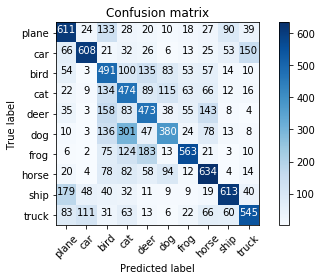

In [14]:
exercise_1_2((5,5))

Try 3x3, 3x4, 3x5, 4x4 and 5x5 mask,and get the accuracies 55%, 56%, 56%, 55%, 56% and 53% respectively. They are really close to each other and it seems to be very hard to come to some a conclusion.

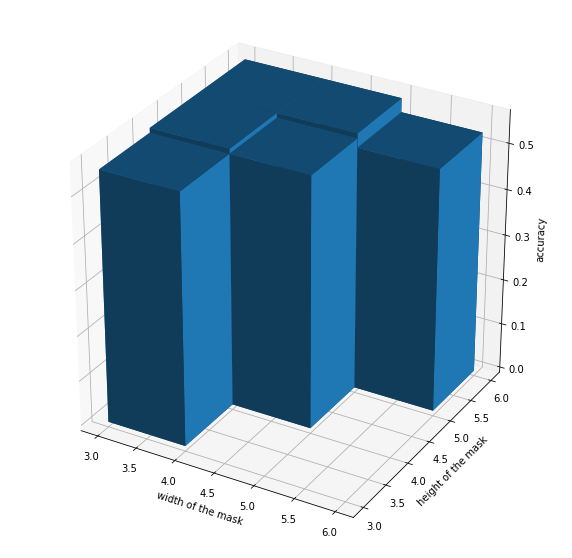

In [51]:
# collect the data from the above experiments
X = [3, 3, 3, 4, 4, 5]
Y = [3, 4, 5, 4, 5, 5]
Z = [0.55, 0.56, 0.56, 0.55, 0.56, 0.53]

figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(111, projection='3d')

# visualize the data
bottom = np.zeros_like(Z)
width = depth = np.ones_like(X)

ax.bar3d(X, Y, bottom, width, depth, Z, shade=True)

ax.set_xlabel('width of the mask')
ax.set_ylabel('height of the mask')
ax.set_zlabel('accuracy')
plt.show()


3. Change the number of filters at the first convolution layer 
    and tabulate performance. I am going to test it with 4, 8, 16, 32 and 64 filters respectively.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn import metrics

import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function is going to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


class Net(nn.Module):
    """
    This class is my customized CNN model.
    It receives an optional 2-dimension tuple to set the mast size
    """

    def __init__(self, number_of_filters):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, number_of_filters, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(number_of_filters, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


######################################################################
# common variables

# initialize the training-set and test-set variables
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

training_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
training_set_loader = torch.utils.data.DataLoader(training_set, batch_size=4,
                                                  shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                              shuffle=False, num_workers=2)

class_tuple = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
               'frog', 'horse', 'ship', 'truck')
class_list = list(class_tuple)


################################################################
# encapsulated function for exercise 1-3 

def exercise_1_3(number_of_filters):
    """
    This function is going to be called to train the data,
        and test with different filters.
    :param mask_size: a positive number to set the filter number
    :return:
    """

    ############################################################
    # create an object of our CNN model with the specific mask
    net = Net(number_of_filters)

    ############################################################
    # Define a Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    ############################################################
    # train it with the training data
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(training_set_loader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

    ############################################################
    # test it with the testing set
    correct = 0
    total = 0
    actual_values = []
    predicted_values = []
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in test_set_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(4):
                predicted_values.append(class_tuple[predicted[i]])
                actual_values.append(class_tuple[labels[i]])
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))

    ############################################################
    # generate the confusion matrix
    plt.figure()
    matrix = metrics.confusion_matrix(actual_values, predicted_values, class_list)
    plot_confusion_matrix(matrix, class_list)
    plt.show()


Files already downloaded and verified
Files already downloaded and verified


* test with 4 filters

[1,  2000] loss: 2.193
[1,  4000] loss: 1.892
[1,  6000] loss: 1.727
[1,  8000] loss: 1.638
[1, 10000] loss: 1.576
[1, 12000] loss: 1.529
[2,  2000] loss: 1.457
[2,  4000] loss: 1.452
[2,  6000] loss: 1.432
[2,  8000] loss: 1.382
[2, 10000] loss: 1.387
[2, 12000] loss: 1.379
Finished Training
Accuracy of the network on the 10000 test images: 50 %


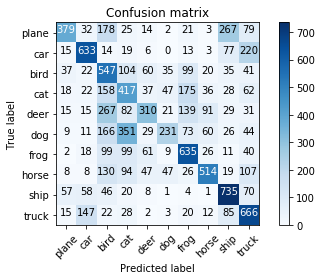

In [14]:
exercise_1_3(4)


* test with 6 filters

[1,  2000] loss: 2.175
[1,  4000] loss: 1.866
[1,  6000] loss: 1.654
[1,  8000] loss: 1.573
[1, 10000] loss: 1.506
[1, 12000] loss: 1.478
[2,  2000] loss: 1.411
[2,  4000] loss: 1.382
[2,  6000] loss: 1.367
[2,  8000] loss: 1.346
[2, 10000] loss: 1.316
[2, 12000] loss: 1.284
Finished Training
Accuracy of the network on the 10000 test images: 53 %


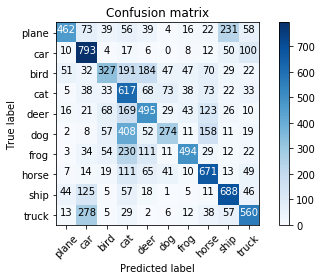

In [9]:
exercise_1_3(6)


* test with 16 filters

[1,  2000] loss: 2.166
[1,  4000] loss: 1.792
[1,  6000] loss: 1.638
[1,  8000] loss: 1.517
[1, 10000] loss: 1.478
[1, 12000] loss: 1.425
[2,  2000] loss: 1.369
[2,  4000] loss: 1.334
[2,  6000] loss: 1.329
[2,  8000] loss: 1.317
[2, 10000] loss: 1.275
[2, 12000] loss: 1.234
Finished Training
Accuracy of the network on the 10000 test images: 57 %


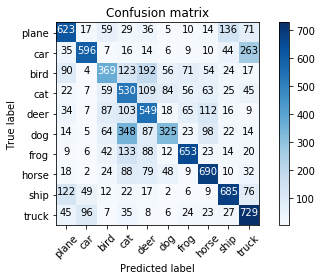

In [10]:
exercise_1_3(8)

[1,  2000] loss: 2.158
[1,  4000] loss: 1.782
[1,  6000] loss: 1.607
[1,  8000] loss: 1.519
[1, 10000] loss: 1.474
[1, 12000] loss: 1.390
[2,  2000] loss: 1.337
[2,  4000] loss: 1.305
[2,  6000] loss: 1.281
[2,  8000] loss: 1.236
[2, 10000] loss: 1.214
[2, 12000] loss: 1.195
Finished Training
Accuracy of the network on the 10000 test images: 58 %


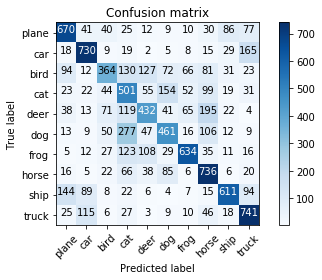

In [15]:
exercise_1_3(16)


* test with 32 filters

[1,  2000] loss: 2.183
[1,  4000] loss: 1.784
[1,  6000] loss: 1.591
[1,  8000] loss: 1.517
[1, 10000] loss: 1.450
[1, 12000] loss: 1.376
[2,  2000] loss: 1.309
[2,  4000] loss: 1.299
[2,  6000] loss: 1.244
[2,  8000] loss: 1.213
[2, 10000] loss: 1.197
[2, 12000] loss: 1.165
Finished Training
Accuracy of the network on the 10000 test images: 59 %


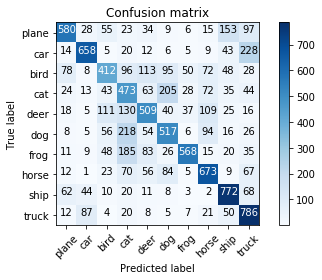

In [12]:
exercise_1_3(32)


* test with 64 filters

[1,  2000] loss: 2.125
[1,  4000] loss: 1.720
[1,  6000] loss: 1.538
[1,  8000] loss: 1.480
[1, 10000] loss: 1.408
[1, 12000] loss: 1.338
[2,  2000] loss: 1.279
[2,  4000] loss: 1.222
[2,  6000] loss: 1.205
[2,  8000] loss: 1.169
[2, 10000] loss: 1.158
[2, 12000] loss: 1.132
Finished Training
Accuracy of the network on the 10000 test images: 60 %


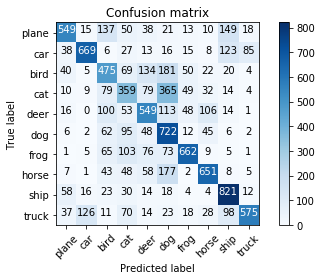

In [13]:
exercise_1_3(64)


Now, to visualize the performance with different numbers of filters. Apparently, the more filters there are, the more accurate it is and the longer it takes to run. Moreover, numbers of filters become less significant when it is above 16.

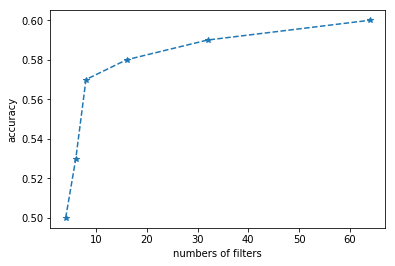

In [19]:
X = [4, 6, 8, 16, 32, 64]
Y = [0.50, 0.53, 0.57, 0.58, 0.59, 0.60]

figure = plt.figure()
plt.plot(X, Y, '--*')
plt.xlabel('numbers of filters')
plt.ylabel('accuracy')
plt.show()

4. Select a subset of 100 test images. Measure the accuracy on the
    subset using any of the trained models from Steps 1-3 above.
    Next, flip the test images at random either horizontally or
    vertically and measure the accuracy again. Comment on the results.

I am going to use the model in exercise 1-2 with a 3x3 mask, becuase it is well-organized. It will work here with a little bit change.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn import metrics

import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function is going to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


class Net(nn.Module):
    """
    This class is my customized CNN model.
    It receives an optional 2-dimension tuple to set the mast size
    """

    def __init__(self, mask_size=(3, 3)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, mask_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


######################################################################
# common variables

# initialize the training-set and test-set variables
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# flip transform
flip_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(np.full(3, 0.5), np.full(3, 0.5))
    ]
)

training_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
training_set_loader = torch.utils.data.DataLoader(training_set, batch_size=4,
                                                  shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                              shuffle=False, num_workers=2)

# flip data set
flip_test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, 
                                             transform=flip_transform)

flip_test_set_loarder = torch.utils.data.DataLoader(flip_test_set, batch_size=4,
                                                   shuffle=True, num_workers=2)


class_tuple = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
               'frog', 'horse', 'ship', 'truck')
class_list = list(class_tuple)


def exercise_1_4(test_set_loader):
    """
    This function is going to be called to train the data,
        and test on specfic test set
    :param test_set_loader: loader of the test set
    :return:
    """

    ############################################################
    # create an object of our CNN model with the specific mask
    net = Net()

    ############################################################
    # Define a Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    ############################################################
    # train it with the training data
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(training_set_loader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

    ############################################################
    # test it with the testing set
    correct = 0
    total = 0
    actual_values = []
    predicted_values = []
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for i, data in enumerate(test_set_loader, 0):
            
            # select first 100 images to compromise the test set
            if i == 25:
                break 
            
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(4):
                predicted_values.append(class_tuple[predicted[i]])
                actual_values.append(class_tuple[labels[i]])
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))

    ############################################################
    # generate the confusion matrix
    plt.figure()
    matrix = metrics.confusion_matrix(actual_values, predicted_values, class_list)
    plot_confusion_matrix(matrix, class_list)
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


* first, to test it on the original 100 images

[1,  2000] loss: 2.178
[1,  4000] loss: 1.887
[1,  6000] loss: 1.726
[1,  8000] loss: 1.614
[1, 10000] loss: 1.535
[1, 12000] loss: 1.479
[2,  2000] loss: 1.409
[2,  4000] loss: 1.413
[2,  6000] loss: 1.362
[2,  8000] loss: 1.339
[2, 10000] loss: 1.296
[2, 12000] loss: 1.282
Finished Training
Accuracy of the network on the 10000 test images: 65 %


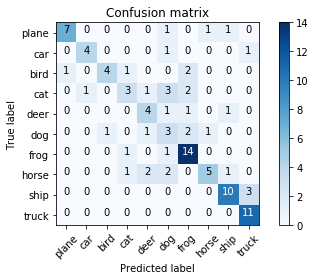

In [23]:
exercise_1_4(test_set_loader)


[1,  2000] loss: 2.218
[1,  4000] loss: 1.863
[1,  6000] loss: 1.685
[1,  8000] loss: 1.581
[1, 10000] loss: 1.472
[1, 12000] loss: 1.454
[2,  2000] loss: 1.383
[2,  4000] loss: 1.342
[2,  6000] loss: 1.327
[2,  8000] loss: 1.312
[2, 10000] loss: 1.294
[2, 12000] loss: 1.265
Finished Training
Accuracy of the network on the 10000 test images: 40 %


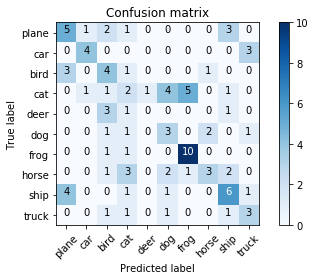

In [24]:
exercise_1_4(flip_test_set_loarder)

It produces about 65% accurate on the original data set and only about 40% on the flipped data set. Apparently, the same model works much worse on the flipped data set. Although these two data sets represent the same objects to some degree from human's perspective, it turns out to be much different from the network's understanding, which results in worse performance.